<a href="https://colab.research.google.com/github/alexandra-florea/JOBarcelona22DS/blob/main/jobarcelona22_ds_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [JOBarcelona ’22 | Data Science Challenge](https://nuwe.io/challenge/jobarcelona-22-data)

In [ ]:
# by Alexandra Florea
# Task 1: EDA

### Background

Nocturnal insects represent one of the most diverse groups of organisms, so it is of the utmost importance to study them.

That is why a group of prestigious entomologists have built an isolated ecosystem with multiple species to be able to study them in greater detail. 

*For this study they are designing a sensor system to be able to automatically track the dynamics and habits of these insects.*

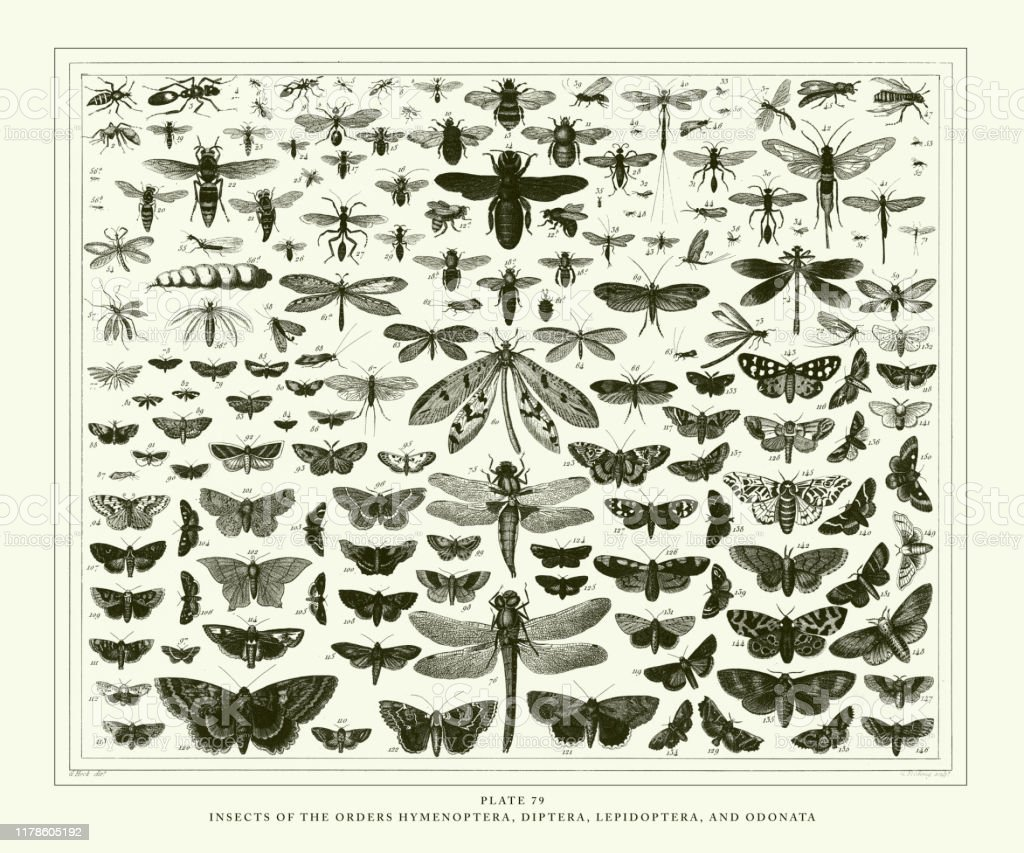

### Deliverables

0. GitHub Repo containing: 
> 1. [x] EDA code (this notebook)
> 2. [x] Predictive model
> 3. [x] 'results.csv' file (3) with the predictions of the algorithm when inputting the test_x dataset. *This file with the results must have a column with the index and another with the 'Insect' predictions.*

### TASK 1: EDA

### Data

---
The customer dataset 'train.csv' contains the following variables:

* **Hour**: Hour at which the measurement was made.

* **Minutes** : Minutes in which the measurement was made.

* **Sensor_alpha** : Position of the insect to the alpha sensor.

* **Sensor_beta** : Position of the insect to the beta sensor.

* **Sensor_gamma** : Position of the insect to the gamma sensor.

* **Sensor_alpha_plus** : Position of the insect to the alpha+ sensor.

* **Sensor_beta_plus** : Position of the insect to the sensor beta+.

* **Sensor_gamma_plus** : Position of the insect to the sensor gamma+.

* **Insect** : Category of insect:

> 0 : Lepidoptera
>
> 1 : Hymenoptera
>
> 2 : Diptera

---



### Bullet-point report of the analysis below

- [x] Exploration of the dataframe and datatypes: 
 - 7001 observations, 9 numerical variables, from which:
  - `Insect` (the dependent variable) is actually categorical, transformations were done to reflect that
  - `Minutes` is not very helpful as such, since butterflies are not on the clock: computed it together with hour into a new float variable `time` 
 - No missing values were identified
 - No duplicates were found
 - Some outliers were identified on the sensors using the Z-score method. No decision was made about them.
- [x] Substantively, and notably:
 - The 3 classes are unbalanced, with Lepidoptera being around 50% of the sample, and Diptera less than 10%.
 - The three species exhibit different behaviors as a function of `time`, with 'Diptera' showing most on the Sensors between 18:00 and 23:59, 'Lepidoptera' between 18:00 and 22:59, and 'Hymenoptera' between 21:00 and 21:59
 - For 3 out of 6 Sensors, proximity to the sensor converges between the species in the interval 20:00 - 21:00. 
 - By contrast, for 'Sensor Alpha Plus' the divergence is particularity stark around 20:00.
 - There is a weak positive correlation between Sensor Gamma and Sensor Beta (0.1), and mild negative correlation between Sensor Alpha Plus and Sensor Beta (-0.5). No other correlations between sensors were identified, which is a good indication that using all the sensors as predictors will not render multicolinearity issues.  
- ❗ Things to keep in mind for the predictive analysis:
 - [x] standardize time and sensors in the pre-processing (with pipes)
 - [x] address class imbalance: experimented with SMOTE, didn't do much. Relying on `F1_macro` as a metric
 - [x] train several classification algorithms, both
    - [x] get a grasp of potential performance across various classification algorithms using `Lazy Predict`
    - [x] AutoML with `mljar`: 
    - [x] manually, with `scikit-learn` : xgboost, lightGBM, CatBoost, Neural networks

---

### EDA

In [1]:
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
pd.options.display.float_format = '{:.3f}'.format

In [ ]:
df = pd.read_csv('/content/train.csv', index_col= "Unnamed: 0")

In [ ]:
df.head()

Hour  Minutes  Sensor_alpha  Sensor_beta  Sensor_gamma  Sensor_alpha_plus  \
0    22       26       119.911      242.838      -316.819            250.195   
1    10       16       -90.791     -269.471      -182.582             95.395   
2    21       42       -20.028     -147.070        50.281            -90.750   
3    21       17       -21.259        0.467       -86.164            -21.814   
4    18       16       -58.155      -13.051      -156.501             48.393   

   Sensor_beta_plus  Sensor_gamma_plus  Insect  
0           -53.548           -112.050       2  
1            37.292             48.525       0  
2           -50.477             85.399       1  
3          -209.256             16.292       0  
4          -110.009            -10.285       2

In [ ]:
df.dtypes

Hour                   int64
Minutes                int64
Sensor_alpha         float64
Sensor_beta          float64
Sensor_gamma         float64
Sensor_alpha_plus    float64
Sensor_beta_plus     float64
Sensor_gamma_plus    float64
Insect                 int64
dtype: object

In [ ]:
df.shape

(7001, 9)

In [ ]:
df.describe()

Hour  Minutes  Sensor_alpha  Sensor_beta  Sensor_gamma  \
count 7001.000 7001.000      7001.000     7001.000      7001.000   
mean    19.599   29.406         0.477      -29.974        -5.625   
std      3.507   17.376        99.295      133.095       115.871   
min      1.000    0.000      -404.899     -656.273      -448.478   
25%     19.000   14.000       -68.574     -116.060       -83.509   
50%     21.000   29.000        -0.287      -36.172        -1.218   
75%     21.000   44.000        66.481       56.638        76.870   
max     23.000   59.000       351.256      518.396       378.349   

       Sensor_alpha_plus  Sensor_beta_plus  Sensor_gamma_plus   Insect  
count           7001.000          7001.000           7001.000 7001.000  
mean               7.188            -0.758             -0.555    0.596  
std              122.328           100.039            100.536    0.662  
min             -437.205          -387.567           -374.962    0.000  
25%              -79.497           -68.062            -69.653    0.000  
50%               -1.134            -0.444              0.027    0.000  
75%               93.285            66.182             67.839    1.000  
max              462.556           345.279            363.682    2.000

#### Missing values, duplicates and outliers detection

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7001 entries, 0 to 7000
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Hour               7001 non-null   int64  
 1   Minutes            7001 non-null   int64  
 2   Sensor_alpha       7001 non-null   float64
 3   Sensor_beta        7001 non-null   float64
 4   Sensor_gamma       7001 non-null   float64
 5   Sensor_alpha_plus  7001 non-null   float64
 6   Sensor_beta_plus   7001 non-null   float64
 7   Sensor_gamma_plus  7001 non-null   float64
 8   Insect             7001 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 547.0 KB


No missing values identified.

In [ ]:
# check for duplicates
duplicates = df[df.duplicated()] 
print(duplicates)

Empty DataFrame
Columns: [Hour, Minutes, Sensor_alpha, Sensor_beta, Sensor_gamma, Sensor_alpha_plus, Sensor_beta_plus, Sensor_gamma_plus, Insect]
Index: []


No duplicates identified.

In [ ]:
# check for univariate outliers using Z-score (the rule of 3 standard deviations away)

                               
def detect_outliers(df):                     # define outlier detection function 
    
    outliers = []                            # initialise outliers list        
    treshold = 3                             # set the treshold to 3
    mean = np.mean(df)                       # compute the mean
    std = np.std(df)                         # compute the standard deviation
    
    for i in df:                               # for loop
        z_score = (i-mean)/std                 # calculate z-score
        if np.abs(z_score) > treshold:         # if the z-score value is larger than the treshold value
            outliers.append(i)                 # append value in outliers list
    return outliers

In [ ]:
outlier_sa = detect_outliers(df['Sensor_alpha'])
print("Univariate outliers on the Sensor Alpha measure:", len(outlier_sa), ", which is", '{:.3f}'.format(len(outlier_sa)/len(df['Sensor_alpha'])),"% of the test set.")

Univariate outliers on the Sensor Alpha measure: 18 , which is 0.003 % of the test set.


In [ ]:
outlier_sb = detect_outliers(df['Sensor_beta'])
print("Univariate outliers on the Sensor Beta measure:", len(outlier_sb), ", which is", '{:.3f}'.format(len(outlier_sb)/len(df['Sensor_beta'])),"% of the test set.")

Univariate outliers on the Sensor Beta measure: 32 , which is 0.005 % of the test set.


In [ ]:
outlier_sg = detect_outliers(df['Sensor_gamma'])
print("Univariate outliers on the Sensor Gamma measure:", len(outlier_sg), ", which is", '{:.3f}'.format(len(outlier_sg)/len(df['Sensor_gamma'])),"% of the test set.")

Univariate outliers on the Sensor Gamma measure: 29 , which is 0.004 % of the test set.


In [ ]:
outlier_sap = detect_outliers(df['Sensor_alpha_plus'])
print("Univariate outliers on the Sensor Alpha Plus measure:", len(outlier_sap), ", which is", '{:.3f}'.format(len(outlier_sap)/len(df['Sensor_alpha_plus'])),"% of the test set.")

Univariate outliers on the Sensor Alpha Plus measure: 17 , which is 0.002 % of the test set.


In [ ]:
outlier_sbp = detect_outliers(df['Sensor_beta_plus'])
print("Univariate outliers on the Sensor Beta Plus measure:", len(outlier_sbp), ", which is", '{:.3f}'.format(len(outlier_sbp)/len(df['Sensor_beta_plus'])),"% of the test set.")

Univariate outliers on the Sensor Beta Plus measure: 22 , which is 0.003 % of the test set.


In [ ]:
outlier_sgp = detect_outliers(df['Sensor_gamma_plus'])
print("Univariate outliers on the Sensor Gamma Plus measure:", len(outlier_sgp), ", which is", '{:.3f}'.format(len(outlier_sgp)/len(df['Sensor_gamma_plus'])),"% of the test set.")

Univariate outliers on the Sensor Gamma Plus measure: 17 , which is 0.002 % of the test set.


In [ ]:
outliers = outlier_sa + outlier_sb + outlier_sg + outlier_sap + outlier_sbp + outlier_sgp

print("Sum of Univariate outliers on all Sensors:", len(outliers), ", which is", '{:.3f}'.format(len(outliers)/7001),"% of the test set.")


Sum of Univariate outliers on all Sensors: 135 , which is 0.019 % of the test set.


#### Explore dependent variable

In [ ]:
# 0 -> Lepidoptera
# 1 -> Hymenoptera
# 2 -> Diptera

insectNum = [0,1,2]
insectNam = ["Lepidoptera", "Hymenoptera", "Diptera"]
df['Species'] = df['Insect']
df['Species'] = df['Species'].replace(insectNum, insectNam)

In [ ]:
df["Species"].value_counts()

Lepidoptera    3519
Hymenoptera    2793
Diptera         689
Name: Species, dtype: int64

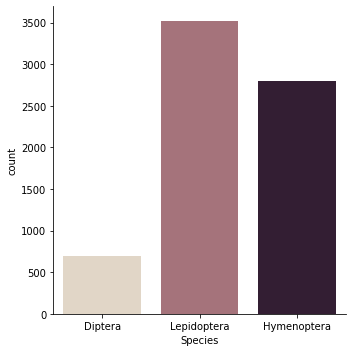

In [ ]:
sns.catplot(x="Species", kind="count", palette="ch:.25", data=df, legend=True)

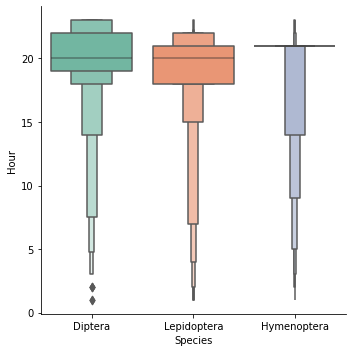

In [ ]:
sns.catplot(x="Species", y="Hour", kind="boxen", palette="Set2", data=df)

#### Dealing with time

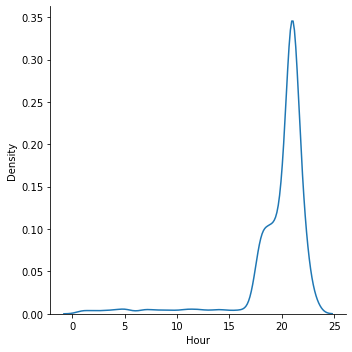

In [ ]:
sns.displot(df, x="Hour", kind="kde")

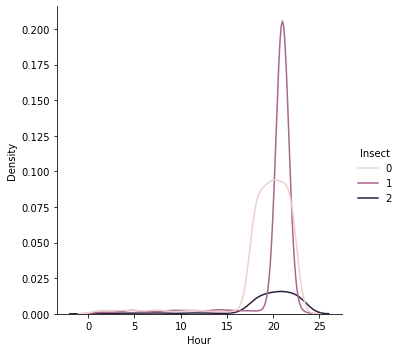

In [ ]:
sns.displot(df, x="Hour", kind="kde", hue="Insect")

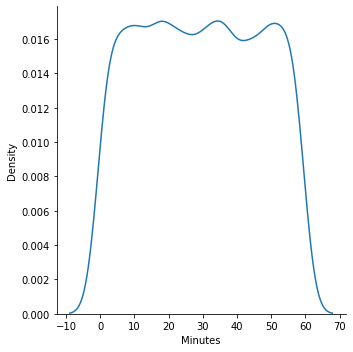

In [ ]:
sns.displot(df, x="Minutes", kind="kde")

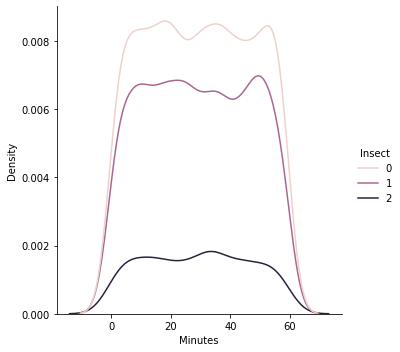

In [ ]:
sns.displot(df, x="Minutes", kind="kde", hue="Insect")

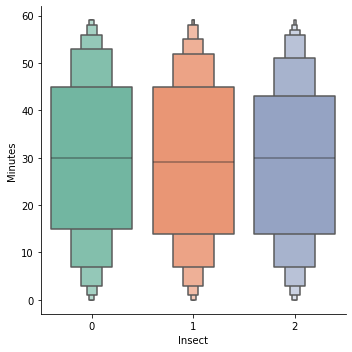

In [ ]:
sns.catplot(x="Insect", y="Minutes", kind="boxen", palette="Set2", data=df)

In [ ]:
df['time'] = (df['Hour']*60+df['Minutes'])/60

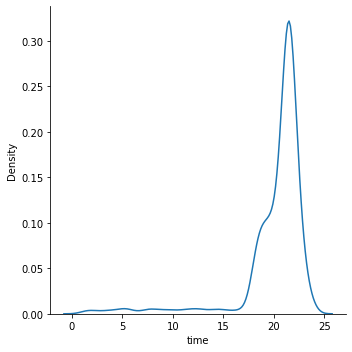

In [ ]:
sns.displot(df, x="time", kind="kde")

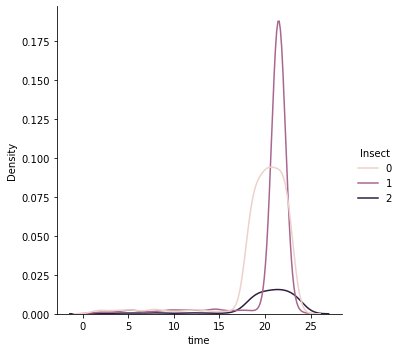

In [ ]:
sns.displot(df, x="time", kind="kde", hue="Insect")

Text(0, 0.5, 'Time')

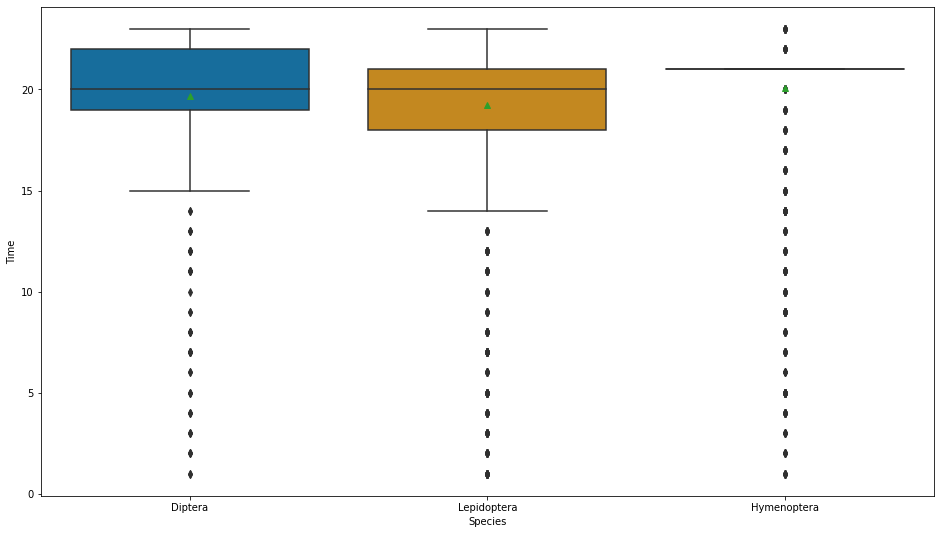

In [ ]:
# time by Insect
sns.boxplot(x=df['Species'], y=df['Hour'], showmeans=True, palette="colorblind");
plt.xlabel('Species')
plt.ylabel('Time')

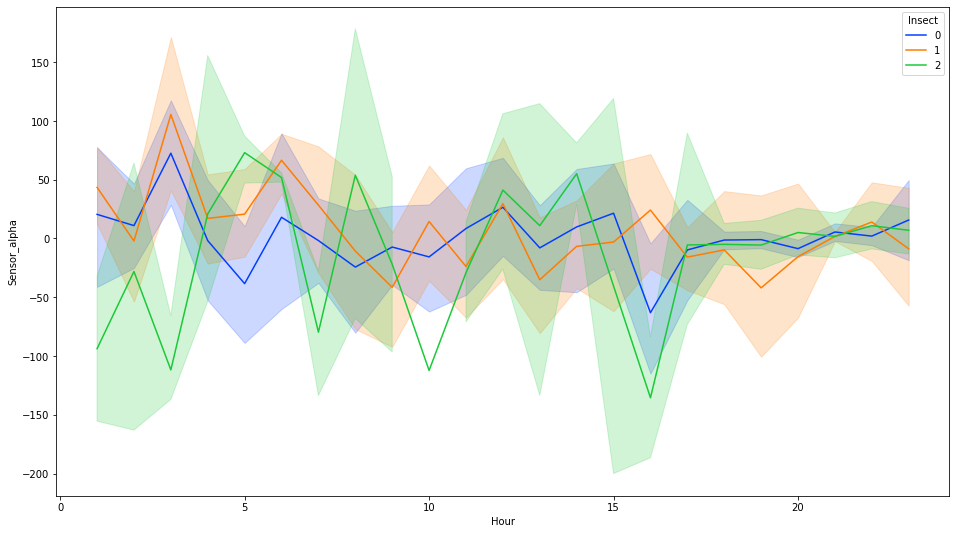

In [ ]:
sns.lineplot(x="Hour", y="Sensor_alpha",
             hue="Insect",
             data=df, palette='bright')

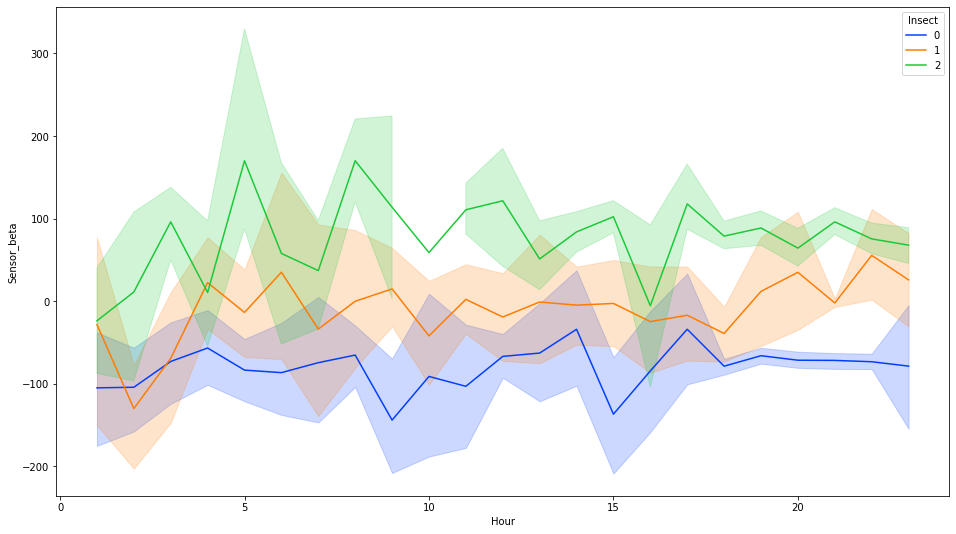

In [ ]:
sns.lineplot(x="Hour", y="Sensor_beta",
             hue="Insect",
             data=df, palette='bright')

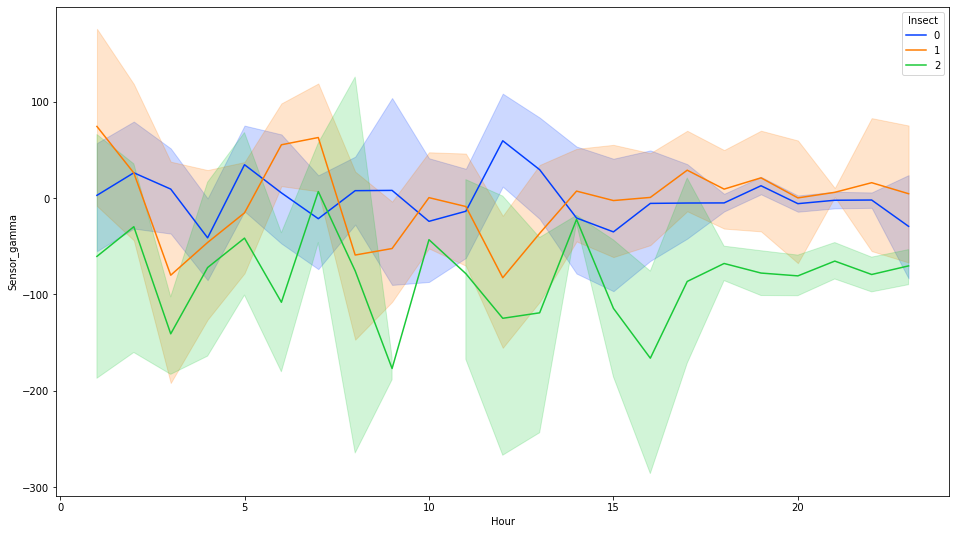

In [ ]:
sns.lineplot(x="Hour", y="Sensor_gamma",
             hue="Insect",
             data=df, palette='bright')

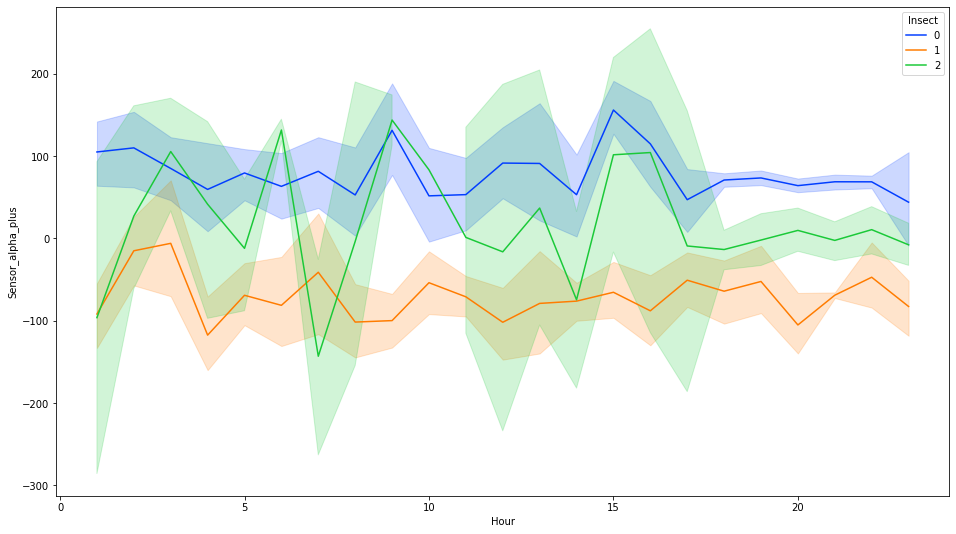

In [ ]:
sns.lineplot(x="Hour", y="Sensor_alpha_plus",
             hue="Insect",
             data=df, palette='bright')

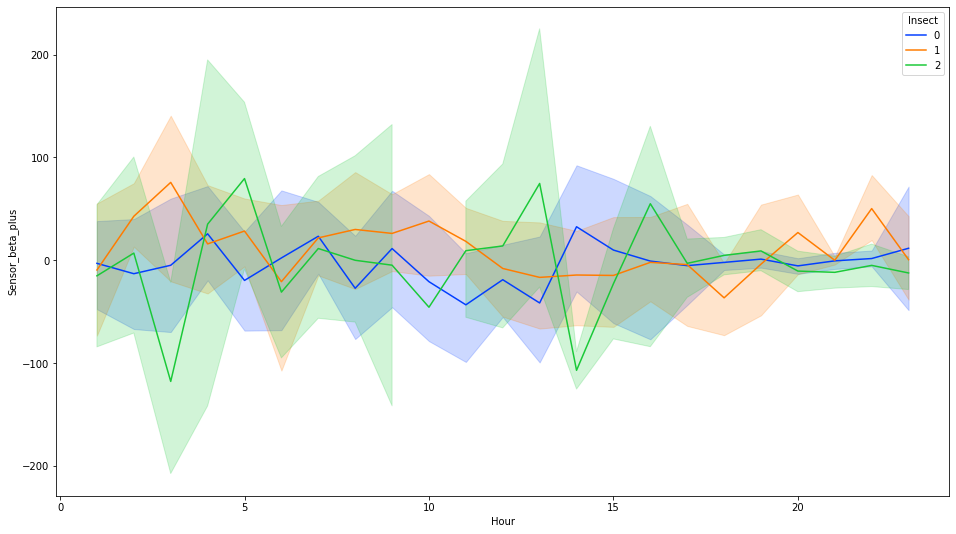

In [ ]:
sns.lineplot(x="Hour", y="Sensor_beta_plus",
             hue="Insect",
             data=df, palette='bright')

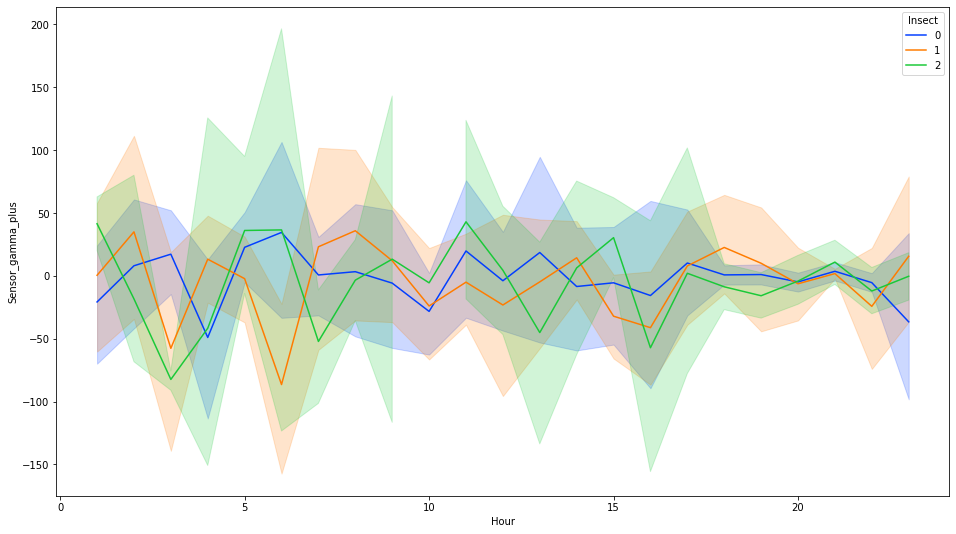

In [ ]:
sns.lineplot(x="Hour", y="Sensor_gamma_plus",
             hue="Insect",
             data=df, palette='bright')

In [ ]:
df['Hour'] = np.digitize(df['Hour'],[0,3,6,9,12,15,18,21,24])

In [ ]:
df.drop(['Minutes'], axis=1, inplace=True)

In [ ]:
df.head()

Hour  Sensor_alpha  Sensor_beta  Sensor_gamma  Sensor_alpha_plus  \
0     8       119.911      242.838      -316.819            250.195   
1     4       -90.791     -269.471      -182.582             95.395   
2     8       -20.028     -147.070        50.281            -90.750   
3     8       -21.259        0.467       -86.164            -21.814   
4     7       -58.155      -13.051      -156.501             48.393   

   Sensor_beta_plus  Sensor_gamma_plus  Insect      Species   time  
0           -53.548           -112.050       2      Diptera 22.433  
1            37.292             48.525       0  Lepidoptera 10.267  
2           -50.477             85.399       1  Hymenoptera 21.700  
3          -209.256             16.292       0  Lepidoptera 21.283  
4          -110.009            -10.285       2      Diptera 18.267

In [ ]:
cols = df.columns.tolist()
cols

['Hour',
 'Sensor_alpha',
 'Sensor_beta',
 'Sensor_gamma',
 'Sensor_alpha_plus',
 'Sensor_beta_plus',
 'Sensor_gamma_plus',
 'Insect',
 'Species',
 'time']

In [ ]:
cols = cols[-1:] + cols[:-1]

In [ ]:
df = df[cols]

In [ ]:
df.head()

time  Hour  Sensor_alpha  Sensor_beta  Sensor_gamma  Sensor_alpha_plus  \
0 22.433     8       119.911      242.838      -316.819            250.195   
1 10.267     4       -90.791     -269.471      -182.582             95.395   
2 21.700     8       -20.028     -147.070        50.281            -90.750   
3 21.283     8       -21.259        0.467       -86.164            -21.814   
4 18.267     7       -58.155      -13.051      -156.501             48.393   

   Sensor_beta_plus  Sensor_gamma_plus  Insect      Species  
0           -53.548           -112.050       2      Diptera  
1            37.292             48.525       0  Lepidoptera  
2           -50.477             85.399       1  Hymenoptera  
3          -209.256             16.292       0  Lepidoptera  
4          -110.009            -10.285       2      Diptera

In [ ]:
df.describe()

time     Hour  Sensor_alpha  Sensor_beta  Sensor_gamma  \
count 7001.000 7001.000      7001.000     7001.000      7001.000   
mean    20.089    7.341         0.477      -29.974        -5.625   
std      3.516    1.238        99.295      133.095       115.871   
min      1.017    1.000      -404.899     -656.273      -448.478   
25%     19.617    7.000       -68.574     -116.060       -83.509   
50%     21.200    8.000        -0.287      -36.172        -1.218   
75%     21.750    8.000        66.481       56.638        76.870   
max     23.983    8.000       351.256      518.396       378.349   

       Sensor_alpha_plus  Sensor_beta_plus  Sensor_gamma_plus   Insect  
count           7001.000          7001.000           7001.000 7001.000  
mean               7.188            -0.758             -0.555    0.596  
std              122.328           100.039            100.536    0.662  
min             -437.205          -387.567           -374.962    0.000  
25%              -79.497           -68.062            -69.653    0.000  
50%               -1.134            -0.444              0.027    0.000  
75%               93.285            66.182             67.839    1.000  
max              462.556           345.279            363.682    2.000

In [ ]:
outlier_time = detect_outliers(df['time'])
print("Univariate outliers on the time measure:", len(outlier_time), ", which is", len(outlier_time)/len(df['time']),"% of the test set.")

Univariate outliers on the time measure: 263 , which is 0.03756606199114412 % of the test set.


#### Explore multivariate relationships

<Figure size 1008x1008 with 0 Axes>

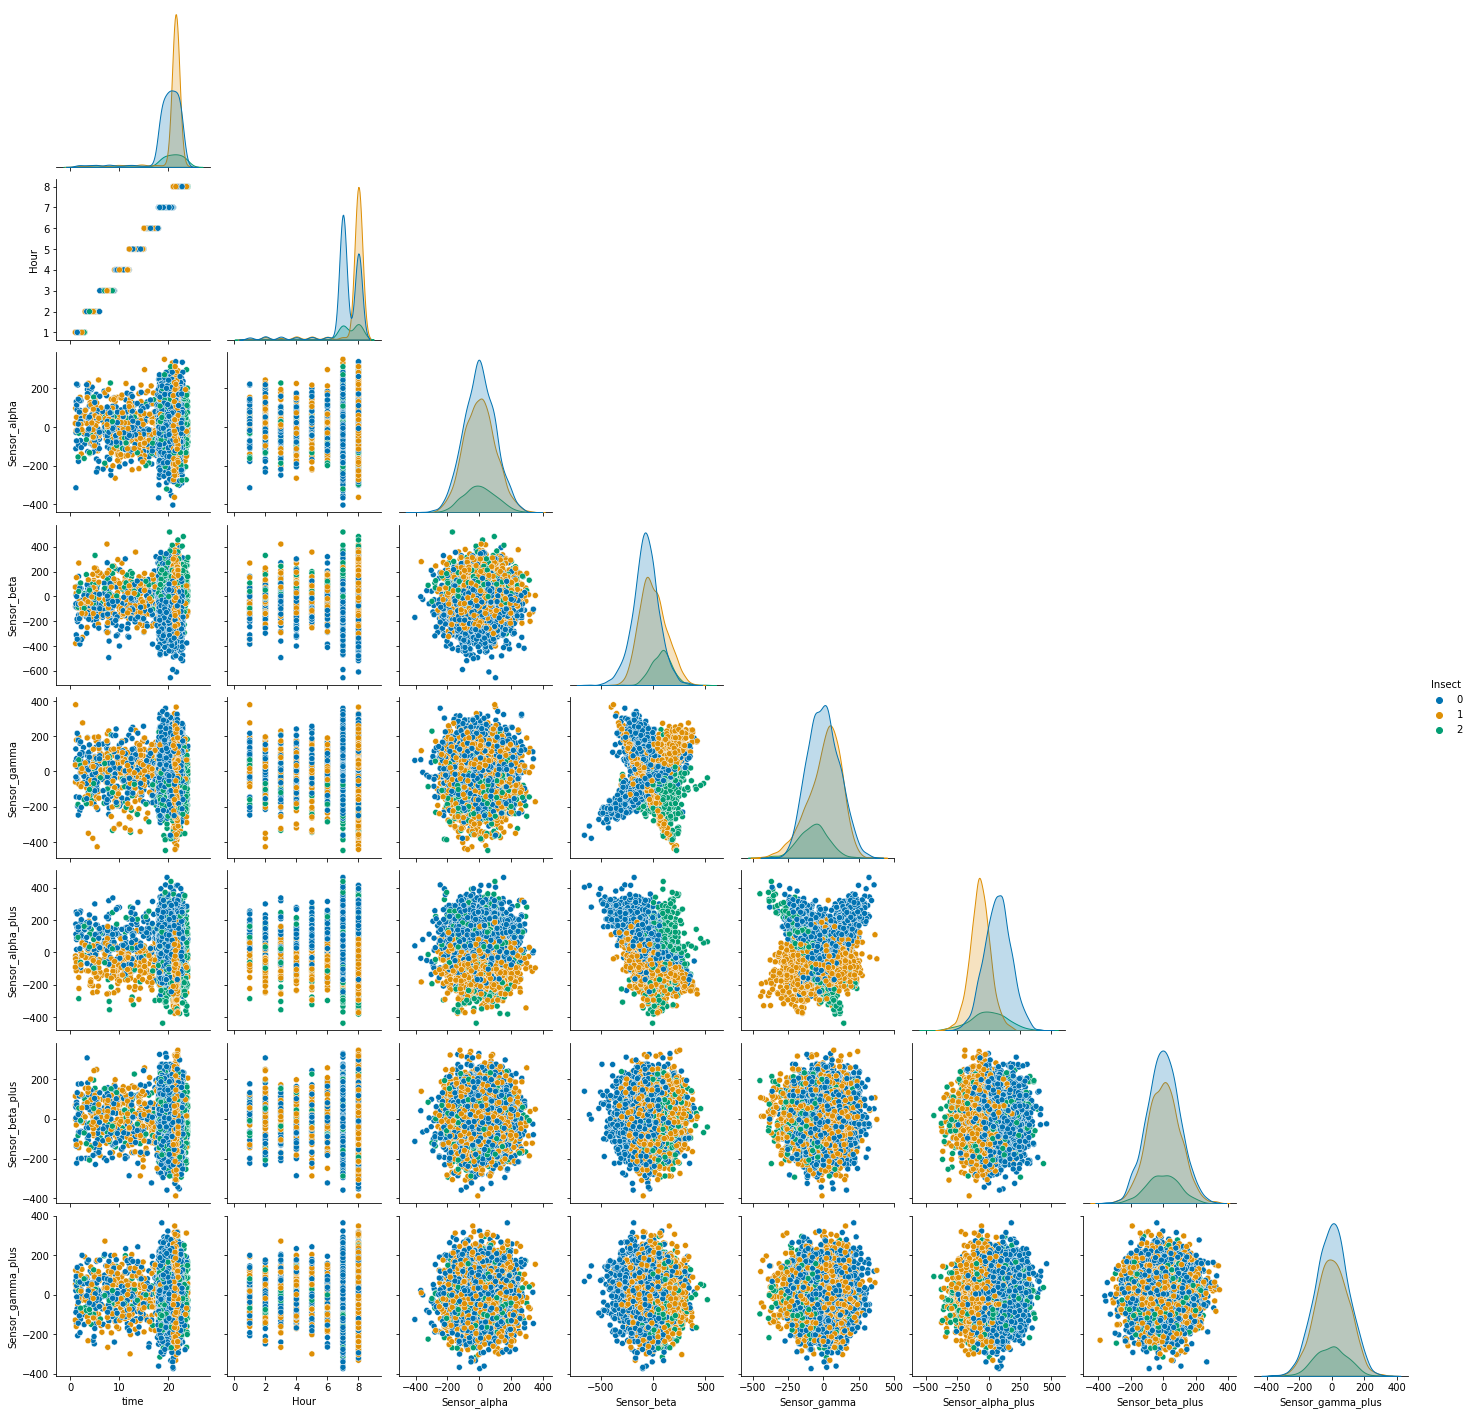

In [ ]:
plt.figure(figsize=(14, 14))

sns.pairplot(df, hue='Insect', diag_kind='kde', palette="colorblind", corner=True)

In [ ]:
dfSens = df[['Sensor_alpha', 'Sensor_beta', 'Sensor_gamma', 'Sensor_alpha_plus', 'Sensor_beta_plus', 'Sensor_gamma_plus']]

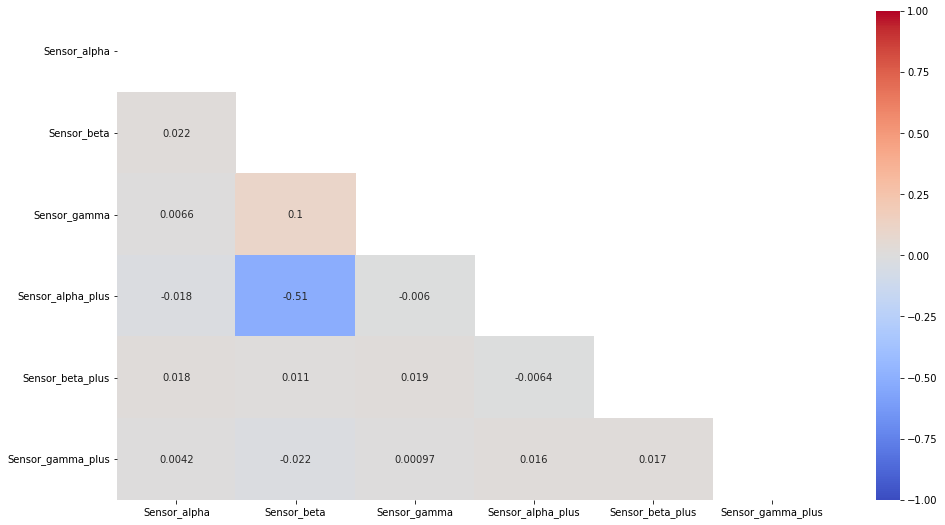

In [ ]:
upp_mat = np.triu(dfSens.corr())

sns.heatmap(dfSens.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)

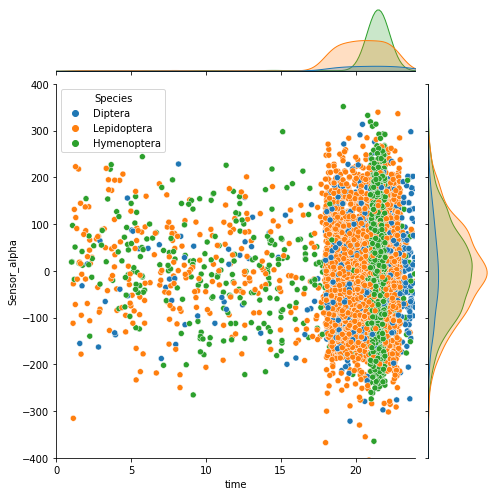

In [ ]:
g = sns.jointplot(x="time", y="Sensor_alpha", data=df,
                  xlim=(0, 24), ylim=(-400, 400),
                  hue='Species', height=7)

In [ ]:
import plotly.express as px

fig = px.density_heatmap(df, x="time", y="Sensor_alpha", facet_col="Insect", text_auto=True, marginal_x="histogram", marginal_y="histogram")
fig.show()

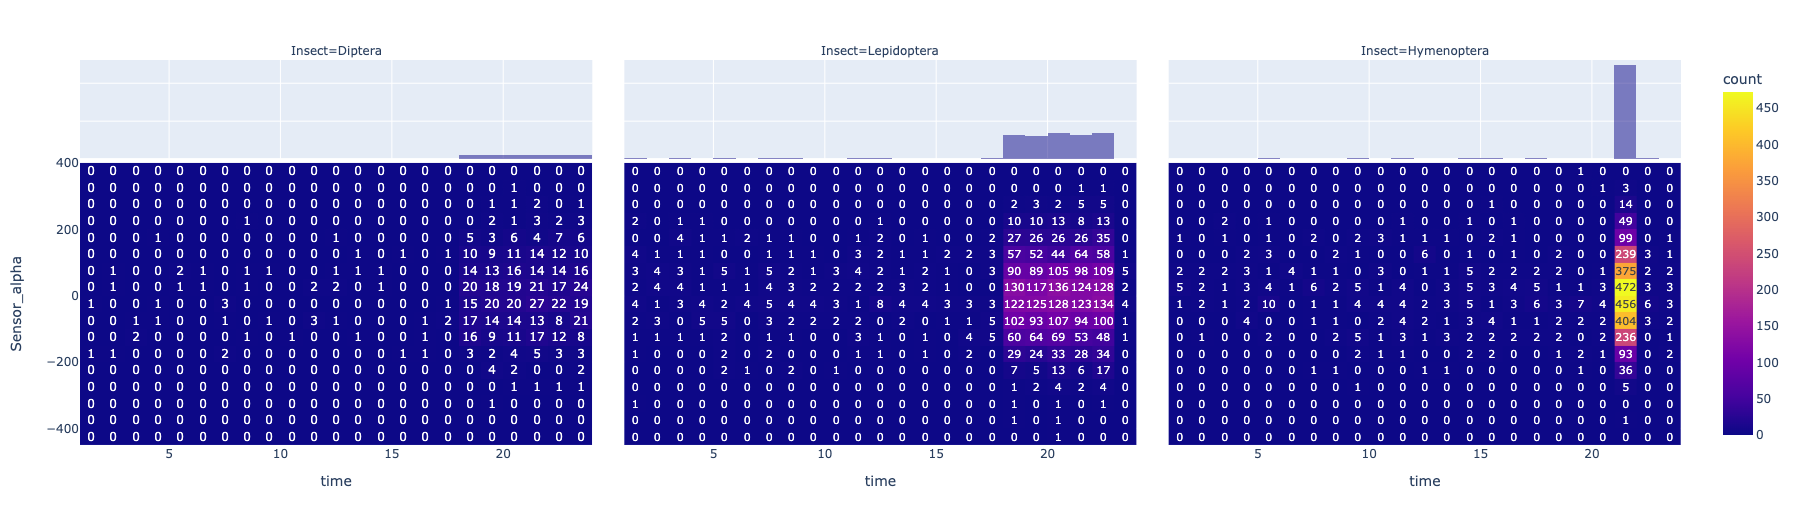

In [ ]:
fig = px.density_heatmap(df, x="time", y="Sensor_beta", facet_col="Insect", text_auto=True, marginal_x="histogram", marginal_y="histogram")
fig.show()

In [ ]:
fig = px.density_heatmap(df, x="time", y="Sensor_gamma", facet_col="Insect", text_auto=True, marginal_x="histogram", marginal_y="histogram")
fig.show()

In [ ]:
fig = px.density_heatmap(df, x="time", y="Sensor_alpha_plus", facet_col="Insect", text_auto=True, marginal_x="histogram", marginal_y="histogram")
fig.show()

In [ ]:
fig = px.density_heatmap(df, x="time", y="Sensor_beta_plus", facet_col="Insect", text_auto=True, marginal_x="histogram", marginal_y="histogram")
fig.show()

In [ ]:
fig = px.density_heatmap(df, x="time", y="Sensor_gamma_plus", facet_col="Insect", text_auto=True, marginal_x="histogram", marginal_y="histogram")
fig.show()

In [ ]:
import plotly.express as px

fig = px.parallel_coordinates(df, color="Insect", labels={"Insect": "Insect",
                "Sensor_alpha": "Sensor Alpha", "Sensor_beta": "Sensor beta",
                "Sensor_gamma": "Sensor_gamma", "Sensor_alpha_plus": "Sensor_alpha_plus", "Sensor_beta_plus": "Sensor_beta_plus",
                "Sensor_gamma_plus": "Sensor_gamma_plus"}
                             )
fig.show()

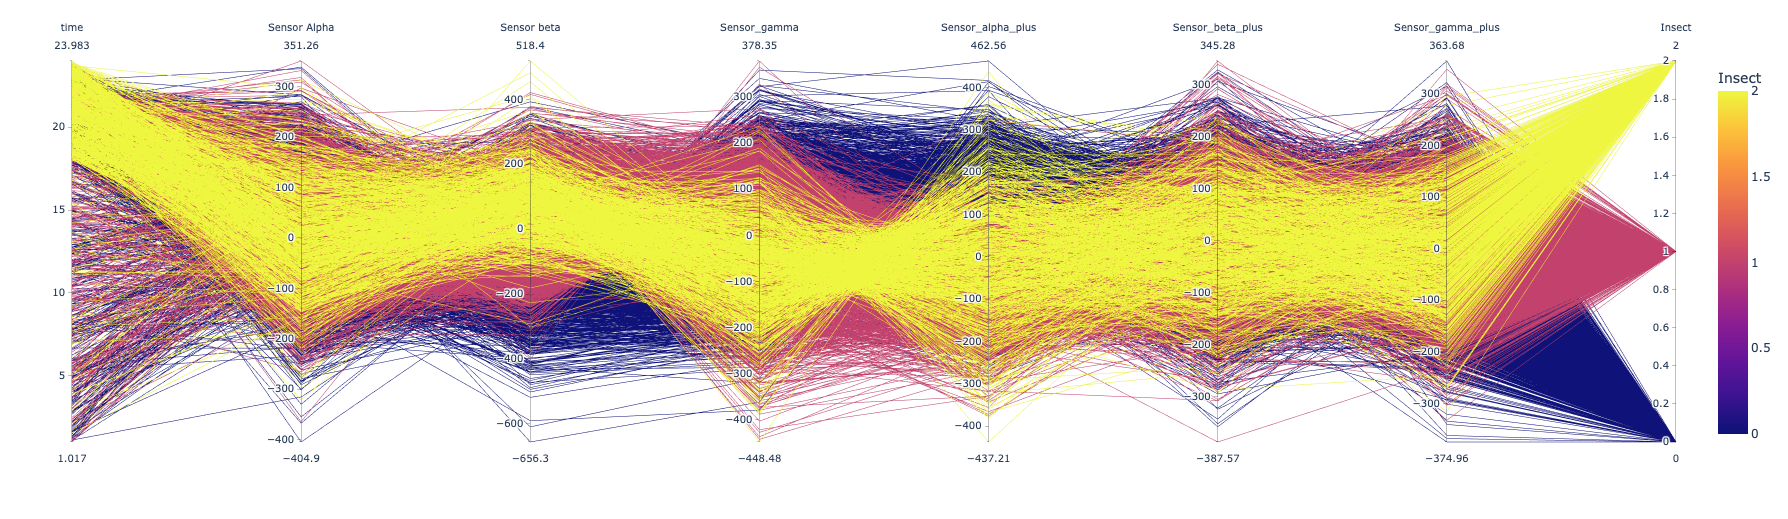

In [ ]:
dfSi = df[['Sensor_alpha', 'Sensor_beta', 'Sensor_gamma', 'Sensor_alpha_plus', 'Sensor_beta_plus', 'Sensor_gamma_plus','Species']]

In [ ]:
dfSi["id"] = dfSi.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
dfSi.head()

Sensor_alpha  Sensor_beta  Sensor_gamma  Sensor_alpha_plus  \
0       119.911      242.838      -316.819            250.195   
1       -90.791     -269.471      -182.582             95.395   
2       -20.028     -147.070        50.281            -90.750   
3       -21.259        0.467       -86.164            -21.814   
4       -58.155      -13.051      -156.501             48.393   

   Sensor_beta_plus  Sensor_gamma_plus      Species  id  
0           -53.548           -112.050      Diptera   0  
1            37.292             48.525  Lepidoptera   1  
2           -50.477             85.399  Hymenoptera   2  
3          -209.256             16.292  Lepidoptera   3  
4          -110.009            -10.285      Diptera   4

In [ ]:
dfSi.rename(columns = {'Sensor_alpha':'SensorAlpha',
                       'Sensor_beta':'SensorBeta',	
                       'Sensor_gamma':'SensorGamma',
                       'Sensor_alpha_plus':'SensorAlphaP',
                       'Sensor_beta_plus':'SensorBetaP',
                       'Sensor_gamma_plus':'SensorGammaP'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
dfSi.columns

Index(['SensorAlpha', 'SensorBeta', 'SensorGamma', 'SensorAlphaP',
       'SensorBetaP', 'SensorGammaP', 'Species', 'id'],
      dtype='object')

In [ ]:
dfSiL = pd.melt(dfSi, id_vars=['Species'], value_vars=['SensorAlpha', 'SensorBeta', 'SensorGamma', 'SensorAlphaP',
       'SensorBetaP', 'SensorGammaP'], ignore_index=False)

In [ ]:
dfSiL.dtypes

Species      object
variable     object
value       float64
dtype: object

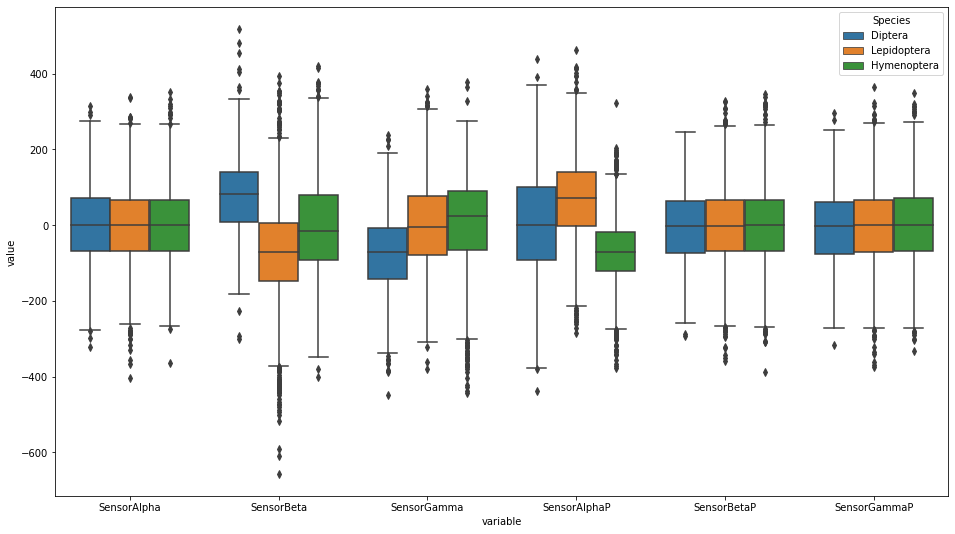

In [ ]:
sns.boxplot(x=dfSiL['variable'],
            y=dfSiL['value'],
            hue=dfSiL['Species'])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

86.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

82.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

84.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

83.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

86.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.p

[Text(0, 0.5, '')]

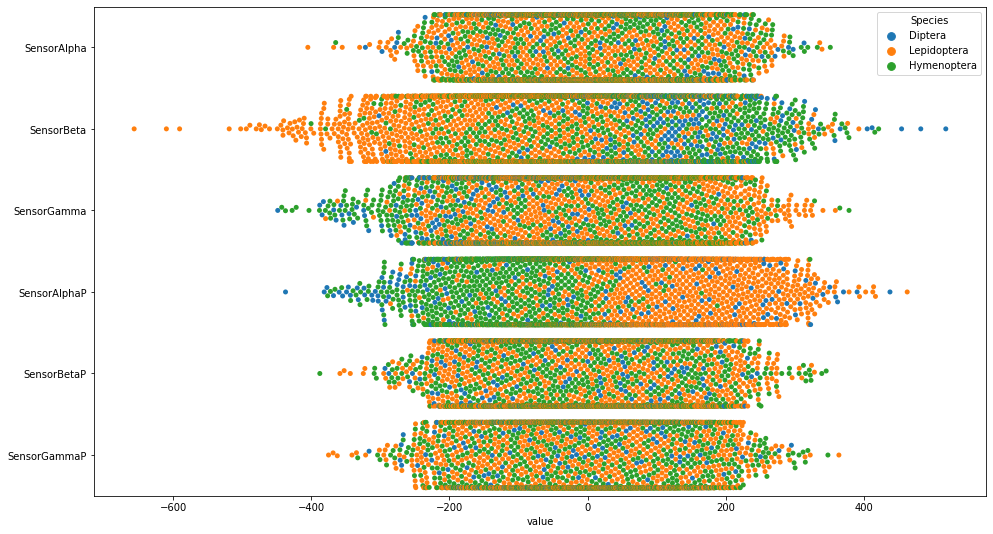

In [ ]:
ax = sns.swarmplot(data=dfSiL, x="value", y="variable", hue="Species")
ax.set(ylabel="")